In [1]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
from numba import njit, prange

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [30]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - 4 * np.pi ** 2 * tf.sin(np.pi * x) * tf.cos(np.pi * x)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return np.sin(np.pi * x) * np.cos(np.pi * x)

geom = dde.geometry.Interval(-2, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

Compiling model...
'compile' took 0.000425 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.46e+03, 2.33e+00]    [1.36e+03, 2.33e+00]    [2.52e+00]    
1000      [9.23e-02, 1.26e-06]    [1.03e-01, 1.26e-06]    [2.89e-02]    
2000      [7.29e-02, 1.31e-10]    [8.11e-02, 1.31e-10]    [2.69e-02]    
3000      [4.85e-02, 4.47e-09]    [5.40e-02, 4.47e-09]    [2.40e-02]    
4000      [2.53e-02, 1.66e-08]    [2.82e-02, 1.66e-08]    [2.09e-02]    
5000      [9.82e-03, 1.66e-08]    [1.16e-02, 1.66e-08]    [1.85e-02]    
6000      [3.27e-03, 4.09e-09]    [5.30e-03, 4.09e-09]    [1.79e-02]    
7000      [1.39e-03, 6.64e-10]    [3.66e-03, 6.64e-10]    [1.87e-02]    
8000      [7.47e-04, 2.36e-10]    [2.61e-03, 2.36e-10]    [1.97e-02]    
9000      [4.56e-03, 2.32e-06]    [5.97e-03, 2.32e-06]    [2.05e-02]    
10000     [3.88e-04, 6.75e-11]    [1.61e-03, 6.75e-11]    [2.03e-02]    

Best model at step 10000:
  train loss: 3.88e-04
  test lo

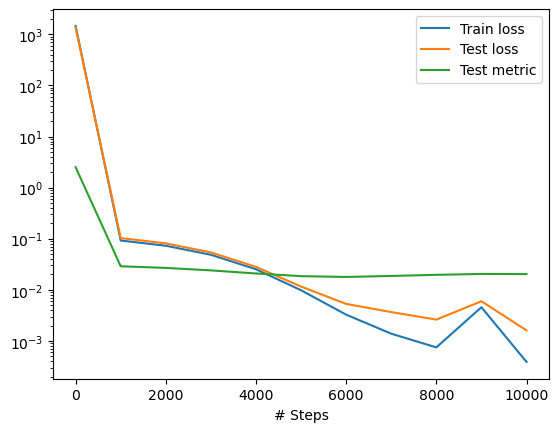

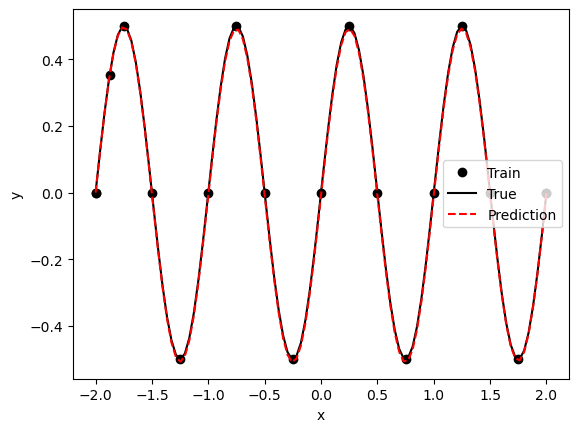

In [39]:
M =200
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R/1000)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [44]:
R = 10
MM = [10, 20, 50, 100, 150, 200]
loss = {}
epochs = {}
metric = {}
for M in MM:
    ll = []
    layer_size = [1] + [M]  +  [1]

    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R/1000)

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[M] = losshistory.steps
    metric[M] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[M] = ll

Compiling model...
'compile' took 0.000454 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.94e+03, 2.34e+00]    [4.57e+03, 2.34e+00]    [3.73e+00]    
1000      [1.80e+02, 4.37e-01]    [1.99e+02, 4.37e-01]    [1.62e+00]    
2000      [3.84e+01, 1.58e+00]    [4.04e+01, 1.58e+00]    [2.33e+00]    
3000      [5.90e+00, 8.79e-01]    [6.26e+00, 8.79e-01]    [1.69e+00]    
4000      [7.00e-01, 1.51e-01]    [5.92e-01, 1.51e-01]    [6.86e-01]    
5000      [3.67e-01, 2.72e-02]    [2.39e-01, 2.72e-02]    [2.68e-01]    
6000      [2.74e-01, 2.44e-02]    [1.77e-01, 2.44e-02]    [2.39e-01]    
7000      [1.84e-01, 3.12e-02]    [1.21e-01, 3.12e-02]    [2.66e-01]    
8000      [1.16e-01, 3.17e-02]    [8.00e-02, 3.17e-02]    [2.66e-01]    
9000      [6.95e-02, 2.34e-02]    [5.18e-02, 2.34e-02]    [2.30e-01]    
10000     [3.88e-02, 1.24e-02]    [3.23e-02, 1.24e-02]    [1.73e-01]    

Best model at step 10000:
  train loss: 5.12e-02
  test lo

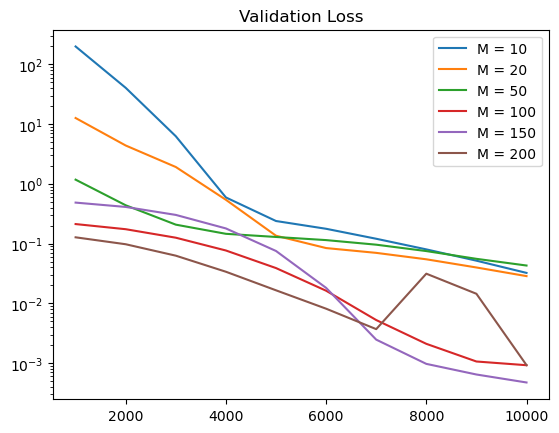

In [45]:
for i in loss:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'M = ' + str(i))
plt.yscale('log')
plt.title('Validation Loss')
plt.legend()
plt.show()